*Group: Austin Wang, Joe Higgins, Lawrence Moore*

The sensor network localization (SNL) problem is easy to understand yet surprisingly complex to solve. Given the distance between a set of anchors and sensors, with the true location of the anchors being known, the goal is to locate the sensors. Yet despite the straightforward statement of the problem, localizing the sensors in a wide variety of configurations presents a major challenge. In this project, we dive deep into two major components of the SNL problem under the assumption that all distance information is known:

 * How do the number of dimensions and anchors along with the starting point and learning rate affect the performance of the algorithms over a *large* number of randomly generated points
 * What algorithmic approach is overall best suited for the problem. To be explicit, we implemented extensible variations of 
     * Second Order Conic Problem (SOCP)  
     * Semi-definite Programming (SDP), with and without noise 
     * Simple non-linear least squares (NLLS)
     * Steepest Descent Method (SDM) with three different schemes for enforcing semi-definiteness

After running 50 simulations for each configuration of dimensions, anchors, and sensors, we found that SDP is the best approach once the number of anchors exceeds the number of dimensions - it always found the sensors. In the case that the number of anchors is less than the number of dimensions, NLLS slightly outpeforms the other two. SOCP performs the worst under almost all circumstances. 

Additionally, we investigated two other aspects of the SNL problem. One was introducing noise to the SDP formulation. Unfortunately we found that it didn't aid in the convergence process. Either the noise would be set to zero at the optimal point, or the resulting incorrect estimate did not lead NLLS to the optimal solution when initialized to that point. For the SDM method, only the eigenvalue decomposition lead to an optimal point. Using only the top 6 eigenvalues did not lead to convergence. The LDL decomposition fails when the solution falls out of the feasible region.

## Question 1: Comparing Average Performance of SOCP, SDP, and NLLS

In previous homeworks, our analysis of SOCP and SDP was mainly concerned with the relative positions of the sensors in the anchor-sensor system. As opposed to focusing on which specific configurations allow the sensors to be localized for the three different methods, in this part of the project we explore the effects of dimensionality and number of anchors on the success rates of the methods.

### Methodology

Our first step was providing an extensible implementation of the SOCP, SDP, and NLLS for a given dimension-number of anchors combination $(d, a)$, where $d \in [1,2,3]$  and  $a \in [2,3,4]$. We fix the number of sensors at 10. The functions run_socp, run_sdp, and run_nlls execute a single run of the methods for given input sensors and input anchors, and return the number of sensors that were located correctly. 

Then, at the beginning of each of 50 trials, we randomly generate sensors and anchors whose coordinates are chosen from $(-2, 2)$ for a given dimension and a given number of anchors. Finally, we count the number of correctly located sensors for each method and display the average number of successes per iteration in the bar graphs that follow. 

In [ ]:
# Import necessary modules
import cvxpy as cvx
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

### Helper functions

#### General Helpers

In [2]:
# Used for generating random anchors and sensors whose coordinates are in [-2,2]
def generate_points(num, dim):
    return np.matrix(4 * np.random.random((num, dim)) - 2)

# For generating the sensor-sensor distances and sensor-anchor distances
def generate_ss_distances(sensors):
    return list(map(lambda s1: 
                list(map(lambda s2: np.linalg.norm(s1 - s2), sensors))
            , sensors))

def generate_sa_distances(sensors, anchors):
    return list(map(lambda s: 
                list(map(lambda a: np.linalg.norm(a - s), anchors))
            , sensors))

# For defining the the matrix-matrix dot product
def sum_elem_product(A,B):
    return cvx.sum_entries(cvx.mul_elemwise(A, B))

# For calculating the number of sensors that are correctly located
def sensor_acc(x, true_sensors):
    num_correct = 0
    for i in range(true_sensors.shape[0]):
        if abs(np.linalg.norm(x[i,:]-true_sensors[i,:])) <= 10**-2:
            num_correct += 1
    return num_correct

#### SDP Helpers

In [3]:
#Make first set of constraint matrices (look like identity)
def enforce_id(sensors):
    dim = np.shape(sensors)[1]
    num_sensors = np.shape(sensors)[0]
    matrices = []
    rhs = []
    for i in range(dim):
        new_matrix = np.zeros((dim+num_sensors, dim+num_sensors))
        new_matrix[i,i] = 1
        matrices.append(new_matrix)
        rhs.append(1)
        
    return (matrices, rhs)

#Make second set of constraint matrices (symmetric holders) 
def enforce_id2(sensors):
    dim = np.shape(sensors)[1]
    num_sensors = np.shape(sensors)[0]
    matrices = []
    rhs = []
    for i in range(dim):
        for j in range(dim):
            new_matrix = np.identity(dim)
            if(j > i):
                new_matrix[i,j] = 1
                new_matrix[j,i] = 1
                big_matrix = np.zeros((dim+num_sensors, dim+num_sensors))
                big_matrix[0:dim,0:dim] = new_matrix
                matrices.append(big_matrix)
                rhs.append(dim)
                
    return (matrices, rhs)


#Make third set of constraint matrices (anchors to sensors)
def sensor_constraints(sensors):
    dim = np.shape(sensors)[1]
    num_sensors = np.shape(sensors)[0]
    d_ss = generate_ss_distances(sensors)
    matrices = []
    rhs = []
    zero_vec_dim = np.zeros(dim)
    for i in range(num_sensors):
        for j in range(i+1, num_sensors):
            zero_vec_num_s = np.zeros(num_sensors)
            zero_vec_num_s[i] = 1
            zero_vec_num_s[j] = -1
            
            new_vec = np.matrix(np.append(zero_vec_dim, zero_vec_num_s))
            
            new_matrix = np.dot(np.transpose(new_vec), new_vec)
            
            matrices.append(new_matrix)
            rhs.append(d_ss[i][j]**2)

    return (matrices, rhs)

#Make fourth set of constraint matrices (sensors to sensors)
def anchor_constraints(sensors, anchors):
    num_sensors = np.shape(sensors)[0]
    num_anchors = np.shape(anchors)[0]
    d_sa = generate_sa_distances(sensors, anchors)
    matrices = []
    rhs = []
    for i in range(num_anchors):
        for j in range(num_sensors):
            zero_vec_num_s = np.zeros(num_sensors)
            zero_vec_num_s[j] = -1

            new_vec = np.append(np.array(anchors[i,:]), np.array(zero_vec_num_s))
            new_vec = np.matrix(new_vec)
            new_matrix = np.dot(np.transpose(new_vec), new_vec)
            matrices.append(new_matrix)
            rhs.append(d_sa[j][i]**2)

    return (matrices, rhs)

#### NLLS Helpers

In [4]:
# Gradient of objective
def grad(sensors, anchors, sens2sens_dist, sens2anc_dist):
    dim = sensors.shape[1]
    sensor_distance_sum = np.zeros((1,dim))
    anchor_distance_sum = np.zeros((1,dim))
    gradient = np.zeros(sensors.shape)

    for i, sensor_i in enumerate(sensors):
        for j, sensor_j in enumerate(sensors):
            if(i != j):
                sensor_distance_sum += (np.linalg.norm(sensor_i - sensor_j)**2 - \
                                        np.linalg.norm(sens2sens_dist[i][j])**2) * \
                                       (sensor_i - sensor_j)

        for k, anchor_k in enumerate(anchors):
            anchor_distance_sum += (np.linalg.norm(anchor_k - sensor_i)**2 - \
                                    np.linalg.norm(sens2anc_dist[i][k])**2) * \
                                   (sensor_i - anchor_k)

        gradient[i,:] = 8*sensor_distance_sum + 4*anchor_distance_sum

    return gradient

#### Individual Method Run Helpers

In [5]:
# Returns the number of correctly located sensors for SOCP
def run_socp(sensors, anchors):
    d_ss = generate_ss_distances(sensors)
    d_sa = generate_sa_distances(sensors, anchors)
    
    dim = sensors.shape[1]
    num_sensors = 10
    num_anchors = anchors.shape[0]
    x = cvx.Variable(num_sensors, dim)
    objective = cvx.Minimize(0)
    
    constraints  = []
    for i in range(num_sensors):
        x_i = x[i, :]
        for j in range(num_anchors):
            constraints.append(cvx.norm(x_i - anchors[j]) <= d_sa[i][j])
        for j in range(num_sensors):
            if i < j:
                constraints.append(cvx.norm(x_i - sensors[j]) <= d_ss[i][j])

    prob = cvx.Problem(objective, constraints)
    result = prob.solve(solver = 'MOSEK')
    return sensor_acc(x.value, sensors)

In [6]:
# Returns the number of correctly located sensors for SDP
def run_sdp(sensors, anchors):    
    
    # Make constraints
    A = enforce_id(sensors)
    B = enforce_id2(sensors)
    C = sensor_constraints(sensors)
    D = anchor_constraints(sensors, anchors)
    
    # Parameters
    dim = sensors.shape[1]
    num_sensors = 10
    num_anchors = anchors.shape[0]
    Z = cvx.Semidef(num_sensors + dim)
    
    constraints = []
    for id_constraint, rhs in zip(A[0], A[1]):
        constraints.append(sum_elem_product(id_constraint, Z) == rhs)
    for id_constraint2, rhs in zip(B[0], B[1]):
        constraints.append(sum_elem_product(id_constraint2, Z) == rhs)
    for sensor_constraint, rhs in zip(C[0], C[1]):
        constraints.append(sum_elem_product(sensor_constraint, Z) == rhs)
    for anchor_constraint, rhs in zip(D[0], D[1]):
        constraints.append(sum_elem_product(anchor_constraint, Z) == rhs)
        
    objective = cvx.Minimize(0)
    prob = cvx.Problem(objective, constraints)
    result = prob.solve(solver = 'MOSEK')
    sol = np.transpose(Z[0:dim, dim:dim+num_sensors].value)
    
    return sensor_acc(sol, sensors)

In [7]:
def run_nlls(sensors, anchors):
    check = 1000
    max_iter = 10000
    k = 0

    # Parameters and initial data
    dim = sensors.shape[1]
    num_sensors = 10
    num_anchors = anchors.shape[0]
    d_ss = generate_ss_distances(sensors)
    d_sa = generate_sa_distances(sensors, anchors)
    
    # Initial sensors guess
    
    # RESULTS QUITE SENSITIVE TO INITIAL GUESS AS WELL
    sensors_0 = np.zeros(sensors.shape)
    sensors_k = sensors_0


    # Iteration
    alpha = .0001 # Result quite sensitive to alpha; chose from empirical evidence
    while check > 10**-6 and k < max_iter:
        sensors_k1 = sensors_k - alpha * grad(sensors_k, anchors, d_ss, d_sa)
        check = np.linalg.norm(sensors_k1 - sensors_k)
        sensors_k = sensors_k1
        k = k+1
    return sensor_acc(sensors_k1, sensors)

In [9]:
# Function that takes in a given dimension dim in [1,2,3] and outputs
# a tuple of 3 lists of lists. Each of these three outer lists corresponds
# to the data for SOCP, SDP, and Nonlinear Least Squares. The inner lists each
# correspond to the number of anchors in [2,3,4]. The values in each of these inner
# lists are the average number of sensors out of the 10 that were located correctly
# out of 50 trials
def execute_solvers(dim):
    SOCP_vals = []
    SDP_vals = []
    NLLS_vals = []
    for anc_i in num_anchors:
        socp_sum = 0
        sdp_sum = 0
        nlls_sum = 0
        for j in range(50):
            # Initialize data for a given trial
            sensors = generate_points(10, dim)
            anchors = generate_points(anc_i, dim)
            
            socp_sum += run_socp(sensors, anchors)
            sdp_sum += run_sdp(sensors, anchors)
            nlls_sum += run_nlls(sensors, anchors)
        SOCP_vals.append(socp_sum/50)
        SDP_vals.append(sdp_sum/50)
        NLLS_vals.append(nlls_sum/50)
        print('Finished One Anchor Iteration')

    return (SOCP_vals, SDP_vals, NLLS_vals)

In [10]:
num_anchors = [2,3,4]

# Results - uncomment the following cells to run solvers
# dim1 = execute_solvers(1)
# dim2 = execute_solvers(2)
# dim3 = execute_solvers(3)

# Results of our simulation (if you don't want to rerun code)
dim1 = ([7.38, 7.5, 7.62], [10.0, 10.0, 10.0], [7.6, 8.8, 9.0])
dim2 = ([2.76, 3.06, 3.6], [0.06, 10.0, 10.0], [3.82, 7.0, 7.82])
dim3 = ([0.62, 0.94, 1.16], [0.0, 0.16, 10.0], [0.0, 2.68, 4.5])

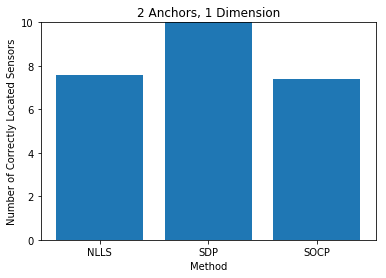

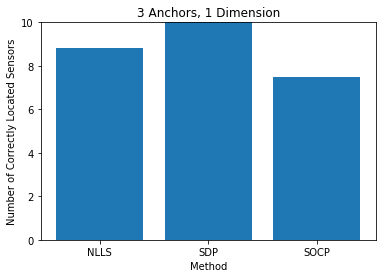

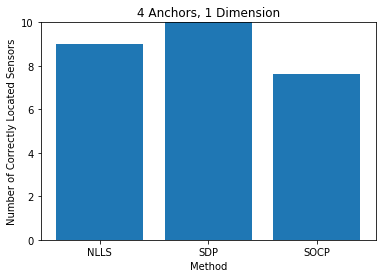

In [47]:
# 1 Dimension

# 2 anchors
plt.figure()
plt.bar(['SOCP','SDP','NLLS'],[i[0] for i in dim1])
plt.title('2 Anchors, 1 Dimension')
plt.xlabel('Method')
plt.ylabel('Number of Correctly Located Sensors')
plt.ylim((0,10))
plt.savefig('anc2_dim1.jpg')

# 3 anchors
plt.figure()
plt.bar(['SOCP','SDP','NLLS'],[i[1] for i in dim1])
plt.title('3 Anchors, 1 Dimension')
plt.xlabel('Method')
plt.ylabel('Number of Correctly Located Sensors')
plt.ylim((0,10))
plt.savefig('anc3_dim1.jpg')

# 4 anchors
plt.figure()
plt.bar(['SOCP','SDP','NLLS'],[i[2] for i in dim1])
plt.title('4 Anchors, 1 Dimension')
plt.xlabel('Method')
plt.ylabel('Number of Correctly Located Sensors')
plt.ylim((0,10))
plt.savefig('anc4_dim1.jpg')

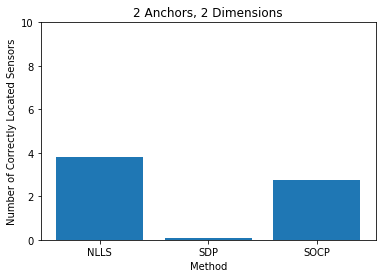

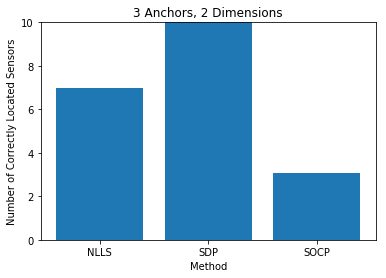

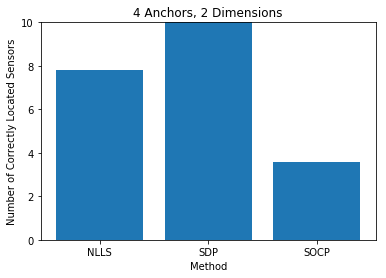

In [48]:
# 2 Dimensions

# 2 anchors
plt.figure()
plt.bar(['SOCP','SDP','NLLS'],[i[0] for i in dim2])
plt.title('2 Anchors, 2 Dimensions')
plt.xlabel('Method')
plt.ylabel('Number of Correctly Located Sensors')
plt.ylim((0,10))
plt.savefig('anc2_dim2.jpg')

# 3 anchors
plt.figure()
plt.bar(['SOCP','SDP','NLLS'],[i[1] for i in dim2])
plt.title('3 Anchors, 2 Dimensions')
plt.xlabel('Method')
plt.ylabel('Number of Correctly Located Sensors')
plt.ylim((0,10))
plt.savefig('anc3_dim2.jpg')

# 4 anchors
plt.figure()
plt.bar(['SOCP','SDP','NLLS'],[i[2] for i in dim2])
plt.title('4 Anchors, 2 Dimensions')
plt.xlabel('Method')
plt.ylabel('Number of Correctly Located Sensors')
plt.ylim((0,10))
plt.savefig('anc4_dim2.jpg')

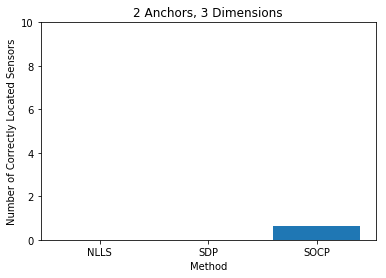

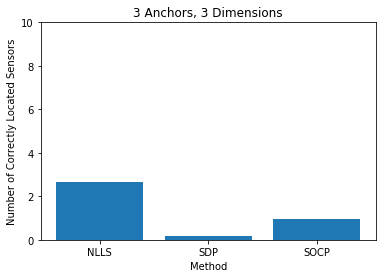

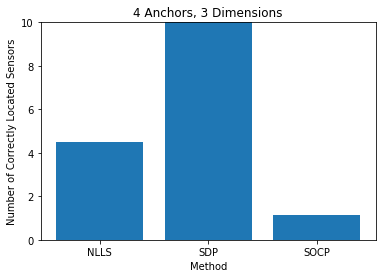

In [49]:
# 3 Dimensions

# 2 anchors
plt.figure()
plt.bar(['SOCP','SDP','NLLS'],[i[0] for i in dim3])
plt.title('2 Anchors, 3 Dimensions')
plt.xlabel('Method')
plt.ylabel('Number of Correctly Located Sensors')
plt.ylim((0,10))
plt.savefig('anc2_dim3.jpg')

# 3 anchors
plt.figure()
plt.bar(['SOCP','SDP','NLLS'],[i[1] for i in dim3])
plt.title('3 Anchors, 3 Dimensions')
plt.xlabel('Method')
plt.ylabel('Number of Correctly Located Sensors')
plt.ylim((0,10))
plt.savefig('anc3_dim3.jpg')

# 4 anchors
plt.figure()
plt.bar(['SOCP','SDP','NLLS'],[i[2] for i in dim3])
plt.title('4 Anchors, 3 Dimensions')
plt.xlabel('Method')
plt.ylabel('Number of Correctly Located Sensors')
plt.ylim((0,10))
plt.savefig('anc4_dim3.jpg')

### Discussion 

For a given dimension, the number of anchors heavily influences which algorithm performs the best. When the number of anchors is less than the number of dimensions, SDP performs the worst, with NLLS performing the best under this condition. However, once the number of anchors exceeds the number of dimensions, SDP finds all ten sensors in every case. Note that we generated the sensors and anchors randomly in a range of 2 across each dimension, which should capture instances of the sensors falling inside the convex hull of the anchors in addition to falling outside. SOCP's performance remains essentially constant across the number of anchors, as it would seem the number of points that fall within the convex hull remains roughly the same. NLLS does better with more anchors, though the increase in performance is not as drastic as with SDP. 

As the number of dimensions increased, the performance of all three algorithms decreased. This was particularly the case with SOCP, where the average number of anchors found for dimension 3 was only around 1. As we saw in the previous homeworks, the convex hull of the anchors plays a critical role in whether the location of the sensors is found for SOCP. Therefore, it makes sense that the increase in dimensions leads to more sensors outside the convex hull, and thus a worse performance overall. 

Changing the focus from dimensionality to initial conditions, we found that the success rate of NLLS is highly dependent on the starting point and the learning rate. In our particular simulations, we used a constant starting point of the origin. We saw that for a given run of the NLLS gradient descent algorithm, there were three possible cases. In the first case, the NLLS was able to exactly locate all 10 sensors. In the second case, the norm of the gradient became quite close to 0, but the algorithm did not converge to the true sensor locations. In the final case, the norm of the gradient blew up. Which case we encountered appears to be directly dependent on the starting point and the learning rate. Although we used the origin as a fixed starting point in our simulations, we also tested starting points that were very near the true sensor locations and very far. For starting points close to the true sensor location, we almost always encountered case 1 if we chose our learning rate small enough. As the starting points became further and further from the true sensor locations, we tended to encounter case 2 more often. In addition, we needed to increase the learning rate to achieve a reasonable convergence speed, but this could lead to an explosion of the gradient, given that we used a constant learning rate in our simulations (i.e. no backtracking). To achieve a reasonable convergence rate using a constant learning rate, and to increase the frequency of convergence to the true sensor locations, we found that a good learning rate was 0.0001.